<a href="https://colab.research.google.com/github/ymiftah/machine_learning/blob/master/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST

## Disclaimer

The following is expanded on examples from Aurélien Géron's book _"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media."_

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

print ("Random seed set to 42")
random.seed(42)

Random seed set to 42


In [0]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
        
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

## Fashion MNIST

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_test = X_test / 255.
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Model creation

We create a two branch model
- A first branch is made of dense layers with selu activation and lecun normal initializer.
- A second branch is made of convolution layers using elu and relu activations

Dropout cells are used to reduce overfitting, without totally erasing it.

In [0]:
# We create our model
def create_model():
    input_ = Input(shape=[28,28])

    # First branch is dense layers
    in_A = Flatten()(input_)
    nn = Dropout(rate=0.2)(in_A)
    for i in range(4):
        nn = Dense(300, activation="selu", kernel_initializer='lecun_normal')(nn)
        nn = Dropout(rate=0.2)(nn)
    
    # Second branch are CNN
    in_B = Reshape((28,28,1))(input_)
    cnn = Conv2D(32, (3, 3), activation='elu',
                kernel_initializer="he_normal", padding='same')(in_B)
    cnn = Conv2D(32, (3, 3), activation='elu',
                kernel_initializer="he_normal",)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.2)(cnn)

    cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)

    cnn = Flatten()(cnn)

    cat = tf.keras.layers.Concatenate()([nn, cnn])
    cat = Dense(256, activation="elu",
                kernel_initializer="he_normal")(cat)

    output = Dense(10, activation="softmax")(cat)
    
    return tf.keras.Model(inputs=[input_], outputs=[output])

In [0]:
model = create_model()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='Adam',
              metrics=["accuracy"])

In [24]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=15,
                    batch_size=32,
                    callbacks=[checkpoint_cb, early_stopping_cb,
                               tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 12s 214us/sample - loss: 0.4347 - acc: 0.8455 - val_loss: 0.2876 - val_acc: 0.8910
Epoch 2/15
55000/55000 [==============================] - 10s 188us/sample - loss: 0.3030 - acc: 0.8870 - val_loss: 0.2593 - val_acc: 0.9054
Epoch 3/15
55000/55000 [==============================] - 11s 191us/sample - loss: 0.2606 - acc: 0.9037 - val_loss: 0.2340 - val_acc: 0.9156
Epoch 4/15
55000/55000 [==============================] - 11s 197us/sample - loss: 0.2362 - acc: 0.9118 - val_loss: 0.2929 - val_acc: 0.8960
Epoch 5/15
55000/55000 [==============================] - 11s 192us/sample - loss: 0.2199 - acc: 0.9183 - val_loss: 0.2280 - val_acc: 0.9178
Epoch 6/15
55000/55000 [==============================] - 11s 195us/sample - loss: 0.2071 - acc: 0.9249 - val_loss: 0.2588 - val_acc: 0.9174
Epoch 7/15
55000/55000 [==============================] - 11s 200us/sample - loss: 0.1932 - acc: 0.9303 -

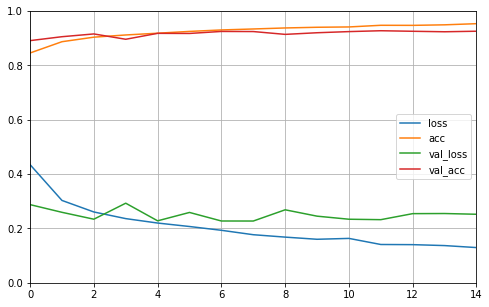

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [26]:
%tensorboard --logdir my_logs

Reusing TensorBoard on port 6007 (pid 241), started 0:08:01 ago. (Use '!kill 241' to kill it.)

In [27]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy is : %.3f' %acc)

Accuracy is : 0.919


Normalized confusion matrix


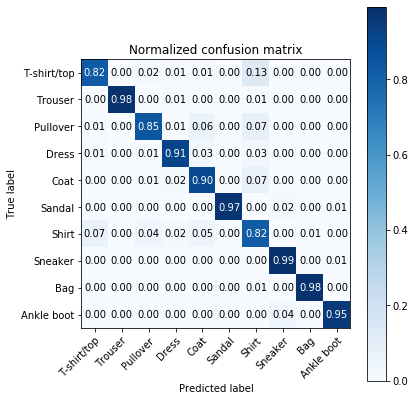

In [28]:
## Code adapted with minimal changes from sklearn
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
##

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Normalized confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    fig, ax = plt.subplots(figsize=(6, 6))
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, without normalization')

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.82      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.90      0.85      0.87      1000
       Dress       0.94      0.91      0.93      1000
        Coat       0.85      0.90      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.72      0.82      0.77      1000
     Sneaker       0.94      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



92 % Accuracy ! Not bad.

We can visualize some predictions

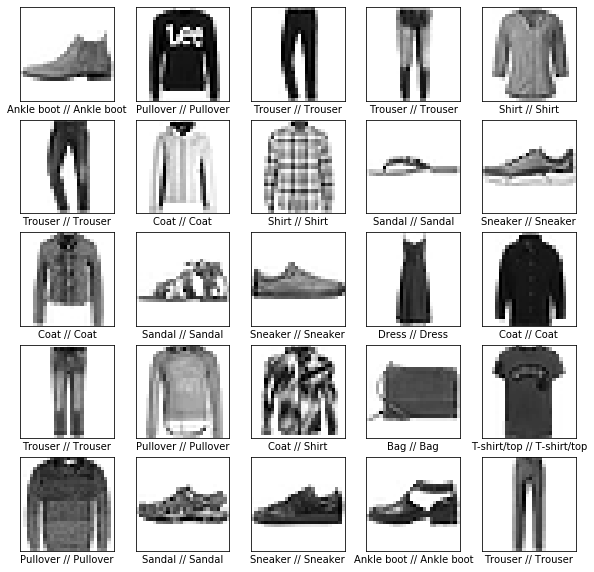

In [30]:
## Credits to kaggler Arunkumar Venkataramanan @https://www.kaggle.com/arunkumarramanan
## https://www.kaggle.com/arunkumarramanan/awesome-cv-with-fashion-mnist-classification

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]] + ' // ' + class_names[y_pred[i]])
plt.show()

We can visualise our model

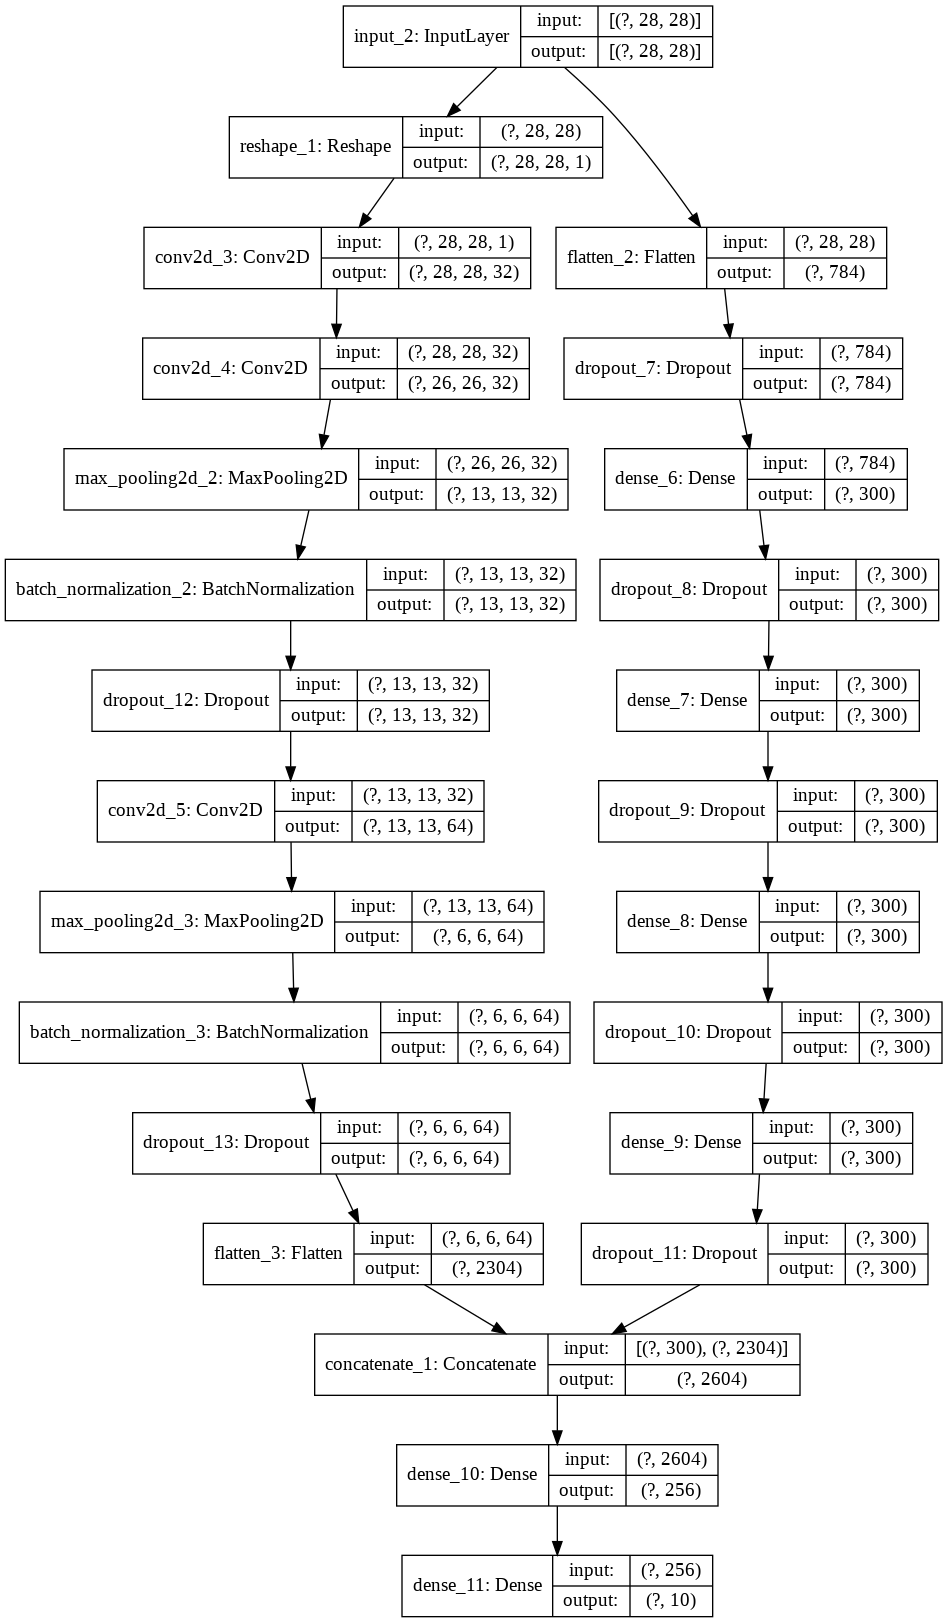

In [31]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)